## Data Visulaization

In [1]:
%matplotlib inline
# import required libraries
import random
import datetime 
import numpy as np
import pandas as pd
from random import randrange

import matplotlib.pyplot as plt

import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('talk')

params = {'legend.fontsize': 'small',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}

plt.rcParams.update(params)

from IPython.display import display, HTML

In [2]:
def _random_date(start,date_count):
    """This function generates a random date based on params
    Args:
        start (date object): the base date
        date_count (int): number of dates to be generated
    Returns:
        list of random dates

    """
    current = start
    while date_count > 0:
        curr = current + datetime.timedelta(days=randrange(42))
        yield curr
        date_count-=1


def generate_sample_data(row_count=100):
    """This function generates a random transaction dataset
    Args:
        row_count (int): number of rows for the dataframe
    Returns:
        a pandas dataframe

    """
    
    # sentinels
    startDate = datetime.datetime(2016, 1, 1,13)
    serial_number_sentinel = 1000
    user_id_sentinel = 5001
    product_id_sentinel = 101
    price_sentinel = 2000
    
    
    # base list of attributes
    data_dict = {
    'Serial No': np.arange(row_count)+serial_number_sentinel,
    'Date': np.random.permutation(pd.to_datetime([x.strftime("%d-%m-%Y") 
                                                    for x in _random_date(startDate,
                                                                          row_count)]).date
                                  ),
    'User ID': np.random.permutation(np.random.randint(0,
                                                       row_count,
                                                       size=int(row_count/10)) + user_id_sentinel).tolist()*10,
    'Product ID': np.random.permutation(np.random.randint(0,
                                                          row_count,
                                                          size=int(row_count/10)) + product_id_sentinel).tolist()*10 ,
    'Quantity Purchased': np.random.permutation(np.random.randint(1,
                                                                  42,
                                                                  size=row_count)),
    'Price': np.round(np.abs(np.random.randn(row_count)+1)*price_sentinel,
                      decimals=2),
    'User Type':np.random.permutation([chr(random.randrange(97, 97 + 3 + 1)) 
                                            for i in range(row_count)])
    }
    
    # introduce missing values
    for index in range(int(np.sqrt(row_count))): 
        data_dict['Price'][np.argmax(data_dict['Price'] == random.choice(data_dict['Price']))] = np.nan
        data_dict['User Type'][np.argmax(data_dict['User Type'] == random.choice(data_dict['User Type']))] = np.nan
        data_dict['Date'][np.argmax(data_dict['Date'] == random.choice(data_dict['Date']))] = np.nan
        data_dict['Product ID'][np.argmax(data_dict['Product ID'] == random.choice(data_dict['Product ID']))] = 0
        data_dict['Serial No'][np.argmax(data_dict['Serial No'] == random.choice(data_dict['Serial No']))] = -1
        data_dict['User ID'][np.argmax(data_dict['User ID'] == random.choice(data_dict['User ID']))] = -101
        
    
    # create data frame
    df = pd.DataFrame(data_dict)
    
    return df
    
    
def cleanup_column_names(df,rename_dict={},do_inplace=True):
    """This function renames columns of a pandas dataframe
       It converts column names to snake case if rename_dict is not passed. 
    Args:
        rename_dict (dict): keys represent old column names and values point to 
                            newer ones
        do_inplace (bool): flag to update existing dataframe or return a new one
    Returns:
        pandas dataframe if do_inplace is set to False, None otherwise

    """
    if not rename_dict:
        return df.rename(columns={col: col.lower().replace(' ','_') 
                    for col in df.columns.values.tolist()}, 
                  inplace=do_inplace)
    else:
        return df.rename(columns=rename_dict,inplace=do_inplace)

def expand_user_type(u_type):
    """This function maps user types to user classes
    Args:
        u_type (str): user type value
    Returns:
        (str) user_class value

    """
    if u_type in ['a','b']:
        return 'new'
    elif u_type == 'c':
        return 'existing'
    elif u_type == 'd':
        return 'loyal_existing'
    else:
        return 'error'
    

### Data Preparaion

In [3]:
df = generate_sample_data(row_count=1000)
cleanup_column_names(df)

df['date'] = pd.to_datetime(df.date)


df['user_class'] = df['user_type'].map(expand_user_type)

df['purchase_week'] = df[['date']].applymap(lambda dt:dt.week 
                                            if not pd.isnull(dt.week) 
                                            else 0)

df = df.dropna(subset=['date'])
df['price'].fillna(value=np.round(df.price.mean(),decimals=2),
                            inplace=True)

In [4]:
#display top 5 rows of df
display(df.head())

,serial_no,date,user_id,product_id,quantity_purchased,price,user_type,user_class,purchase_week
1,1001,2016-01-20,5162,912,34,172.40,n,error,3
3,1003,2016-01-18,5101,265,14,1738.80,n,error,3
4,1004,2016-01-17,5692,432,10,4262.50,n,error,2
6,1006,2016-01-30,5023,209,31,3003.46,n,error,4
7,1007,2016-09-02,5876,852,7,4902.09,n,error,35


#### Visulaizations -Line Chart

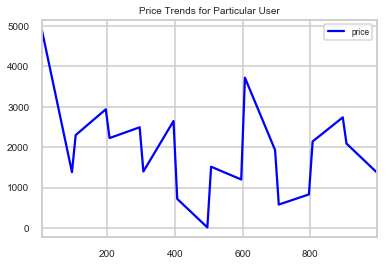

In [5]:
#ploting the price trend for users
max_user_id = df.user_id.value_counts().index[0]
df[df.user_id == max_user_id][['price']].plot(style='blue')
plt.title('Price Trends for Particular User')
plt.show()

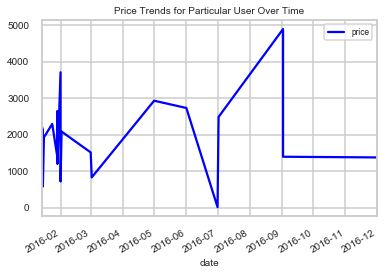

In [6]:
#plotting graph for date vs price 
df[df.user_id == max_user_id].plot(x='date',y='price',style='blue')   
plt.title('Price Trends for Particular User Over Time')
plt.show()

### Bar plot

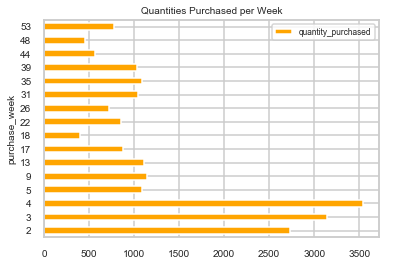

In [7]:
#plot the bar graph for purchased quantities per week

df[['purchase_week',
    'quantity_purchased']].groupby('purchase_week').sum().plot.barh(
                                                            color='orange')
plt.title('Quantities Purchased per Week')
plt.show()

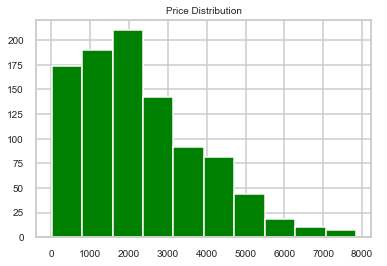

In [8]:
# plot histogram using hist() function
df.price.hist(color='green')
plt.title('Price Distribution')
plt.show()

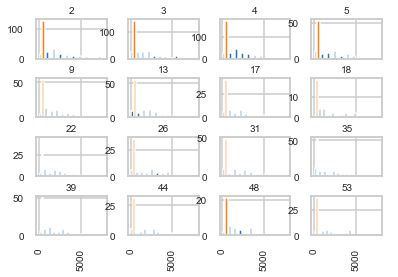

In [9]:
df[['price','purchase_week']].hist(by='purchase_week',sharex=True)
#plt.title('Price Distribution per Week')
plt.show()

#### Pie Charts

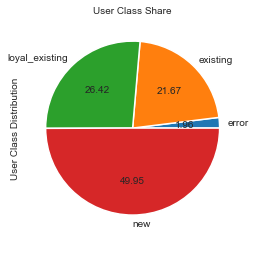

In [10]:
#plotpie chart for user distribution for share class
class_series = df.groupby('user_class').size()
class_series.name = 'User Class Distribution'
class_series.plot.pie(autopct='%.2f')
plt.title('User Class Share')
plt.show()

### Box Plot

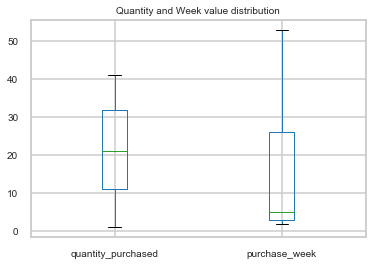

In [11]:
#box plot for quantity purchased and week distribution
df[['quantity_purchased','purchase_week']].plot.box()
plt.title('Quantity and Week value distribution')
plt.show()

### Bubble Charts

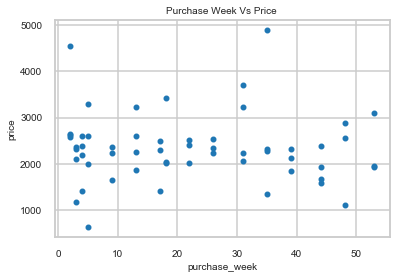

In [16]:
# bubble charts for purchase vs week
uclass_map = {'new': 1, 'existing': 2, 'loyal_existing': 3,'error':0}
df['enc_uclass'] = df.user_class.map(uclass_map) 
bubble_df = df[['enc_uclass',
                'purchase_week',
                'price','product_id']].groupby(['purchase_week',
                                                'enc_uclass']).agg({'price':'mean',
                                                                    'product_id':'count'}).reset_index()
bubble_df.rename(columns={'product_id':'total_transactions'},inplace=True)


bubble_df.plot.scatter(x='purchase_week',
                       y='price')
plt.title('Purchase Week Vs Price ')
plt.show()

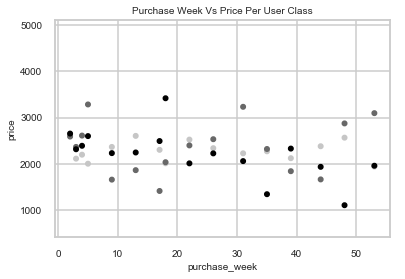

In [13]:
#plot scatter plot for purchase week and price
bubble_df.plot.scatter(x='purchase_week',
                       y='price',
                       c=bubble_df['enc_uclass']) 
plt.title('Purchase Week Vs Price Per User Class')                       
plt.show() 

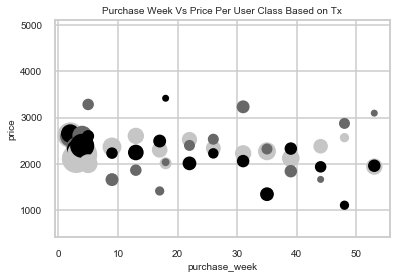

In [17]:

#plot scatter for purchase vs price per user
bubble_df.plot.scatter(x='purchase_week',
                       y='price',
                       c=bubble_df['enc_uclass'],
                       s=bubble_df['total_transactions']*10)
plt.title('Purchase Week Vs Price Per User Class Based on Tx')                          
plt.show()